## References:
1. [Hugginface](https://huggingface.co/vinai/bertweet-base)
2. [Sarcasm Analysis with BERT](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=PGnlRWvkY-2c)

In [2]:
#!pip install transformers

In [2]:
#@title Setup & Config
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import transformers
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
!pwd

/home/sknigam/sarcasm_detection/code/Task_1/BERT Tweet/On Toy/On Raw/Task A En/Final/BERT2


In [4]:
class_names = ['not_sarcastic', 'sarcastic']

In [3]:
path="./"

TypeI=""
TypeII="TweetPreprocessed."
TypeIII="HalfPreprocessed."
TypeIV="FullyPreprocessed."

pathO0="TaskA.En.train.NotAugmented."
pathO1="TaskA.En.train.Augmented."
pathO2="TaskA.En.train.Augmented.NotEmbedding."

pathE0="TaskA.En.train.Augmented.NotBalanced."
pathE1="TaskA.En.train.Augmented.Balanced.Original."
pathE2="TaskA.En.train.Augmented.Balanced.NotOriginal."
pathE3="TaskA.En.train.Augmented.Balanced.NotOriginal.NotEmbedding."


pathB0="TaskA.En.train.Augmented.Biased0.Original."
pathB1="TaskA.En.train.Augmented.Biased1.Original."
pathB2="TaskA.En.train.Augmented.Biased2.Original."
pathB3="TaskA.En.train.Augmented.Biased3.Original."
pathB4="TaskA.En.train.Augmented.Biased4.Original."
pathB5="TaskA.En.train.Augmented.Biased5.Original."
pathB6="TaskA.En.train.Augmented.Biased6.Original."
pathB7="TaskA.En.train.Augmented.Biased7.Original."
pathB8="TaskA.En.train.Augmented.Biased8.Original."
pathB9="TaskA.En.train.Augmented.Biased9.Original."

pathVal="TaskA.En.Basic.Val."
pathTest="TaskA.En.Basic.Test."

In [4]:
chosenPath=pathB4
ChosenType=TypeII
print(chosenPath)
print(ChosenType)

df_train = pd.read_csv(path + chosenPath + ChosenType + "csv")
df_train.dropna(subset = ["tweet","sarcastic"], inplace=True)
df_val = pd.read_csv(path + pathVal + ChosenType + "csv")
df_val.dropna(subset = ["tweet","sarcastic"], inplace=True)
df_test = pd.read_csv(path + pathTest + ChosenType + "csv")
df_test.dropna(subset = ["tweet","sarcastic"], inplace=True)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

TaskA.En.train.Augmented.Biased4.Original.
TweetPreprocessed.
(5158, 10)
(1387, 10)
(1400, 10)


In [7]:
df_train

,tweet_id,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,3388,Whenever I get sad about how things are going ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,"Today's the day, last to chance to sign to sho...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1750,@USER @USER @USER that’s how things like this ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,959,#Dallas #traffic I sure missed you! #not @ Dow...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4834,not enough essays about hozier saying “i slith...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5153,1549,How this isn't just Cowboy Bark listed 100 tim...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5154,4081,"@USER @USER The more liberal the city, the mor...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5155,919,stomach flu once again..what a surprise. #not ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5156,1134,Lutalo's back. Now would be a great time to an...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_val

,tweet_id,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,2861,@USER @USER ppl really don't know what a joke ...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,155,cold queso is so much better than warm queso H...,1,Cold queso is gross and warm queso is so much ...,0.0,1.0,0.0,0.0,0.0,0.0
2,239,@USER @USER You are a right bundle of laughs t...,1,I would say he’s being miserable and not that ...,1.0,0.0,0.0,0.0,0.0,0.0
3,2539,Calling all user researchers: who fancies beta...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3230,@USER how has Marcel Kittle been allowed to us...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1382,660,imma still vote for vermin supreme this presid...,1,I will not be voting for Vermin Supreme this u...,1.0,0.0,0.0,0.0,0.0,0.0
1383,2885,"#NoMoreLockdowns #NoMoreLockdowns, not great. ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1384,2440,Whenever I go to Starbucks I panic while order...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1385,133,@USER @USER @USER @USER @USER Finally someone ...,1,Billionaires do not need anyone to speak up on...,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_test

,tweet_id,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,NaN,"Size on the the Toulouse team, That pack is mo...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Pinball!,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,So the Scottish Government want people to get ...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,villainous pro tip : change the device name on...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,I would date any of these men :pleading_face:,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1395,NaN,I’ve just seen this and felt it deserved a Ret...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1396,NaN,Omg how an earth is that a pen !! :clown_face:,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1397,NaN,Bringing Kanye and drake to a tl near you,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1398,NaN,"I love it when women are referred to as ""girl ...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


train total 5158 sarcastic 3018 non sarcastic 2140


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


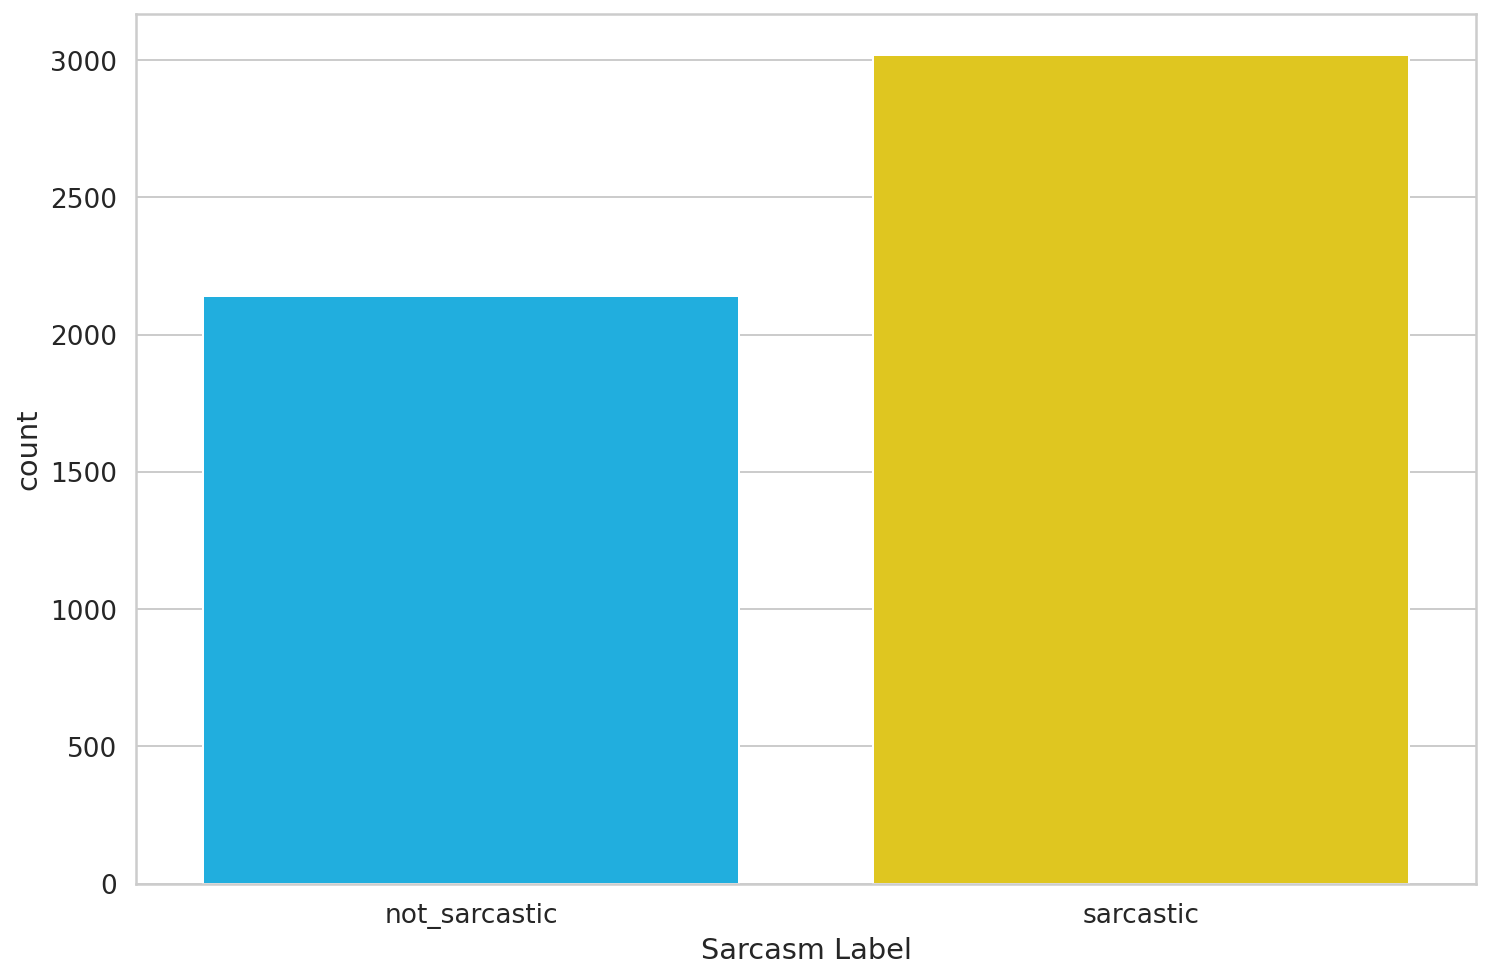

In [10]:
ax = sns.countplot(df_train.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names)
s_train = 0
ns_train =0
for i in df_train.sarcastic:
    if i == 1:
        s_train+=1
    else:
        ns_train+=1
l_count = len(df_train.sarcastic)
print("train total", l_count, "sarcastic", s_train, "non sarcastic", ns_train)

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Val total 1387 sarcastic 347 non sarcastic 1040


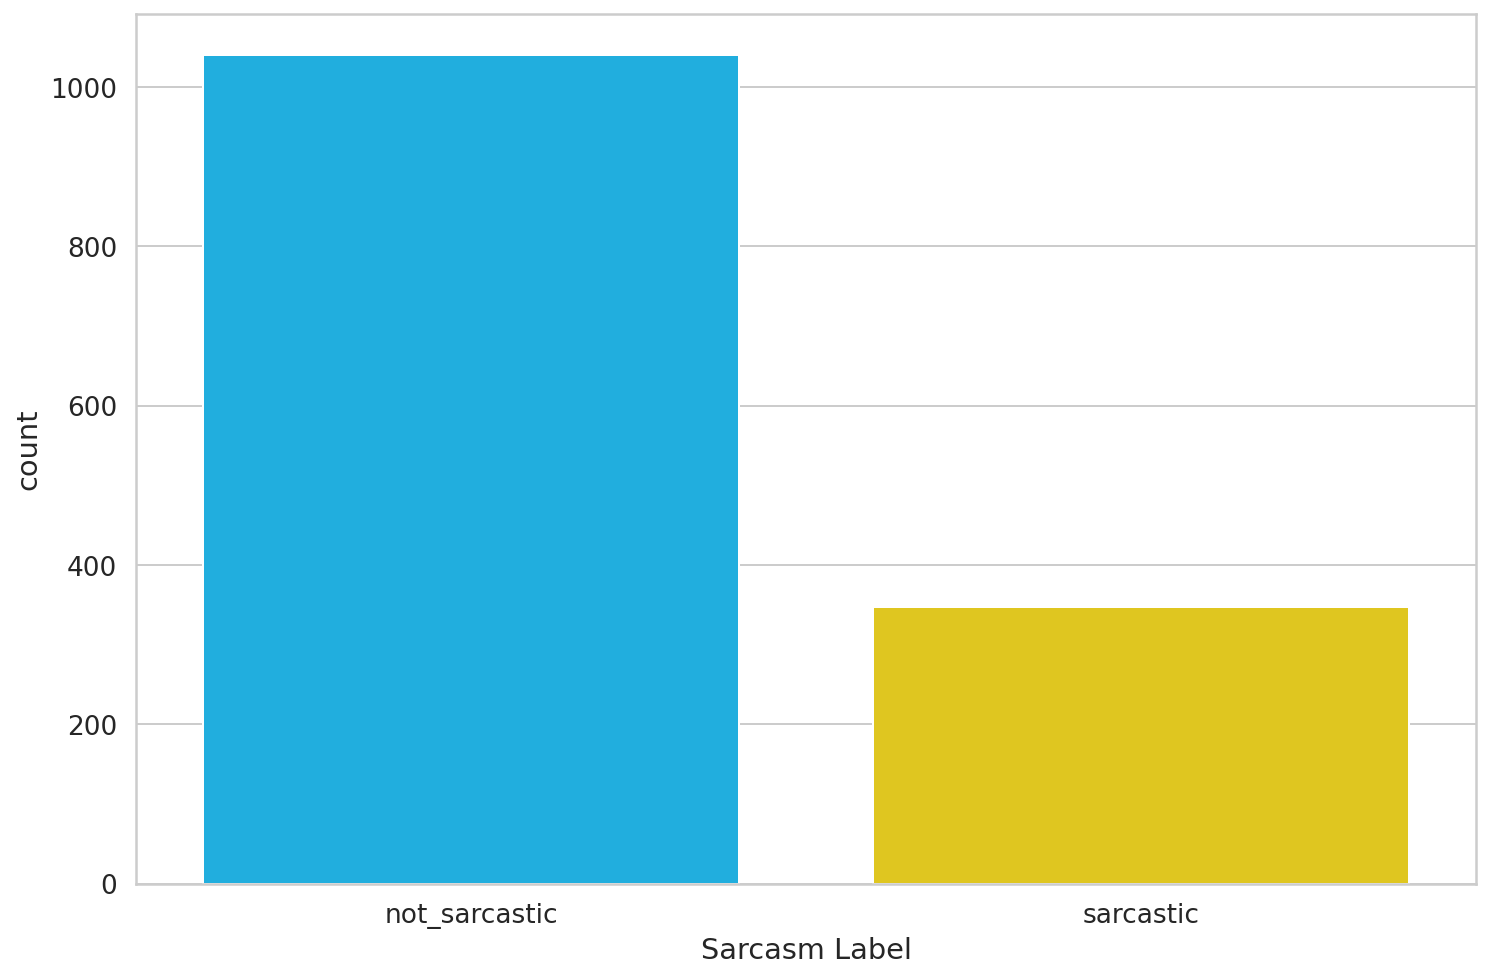

In [11]:
ax = sns.countplot(df_val.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names);
s_t = 0
ns_t =0
for i in df_val.sarcastic:
    if i == 1:
        s_t+=1
    else:
        ns_t+=1
l_count = len(df_val.sarcastic)
print("Val total", l_count, "sarcastic", s_t, "non sarcastic", ns_t)

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


test total 1400 sarcastic 200 non sarcastic 1200


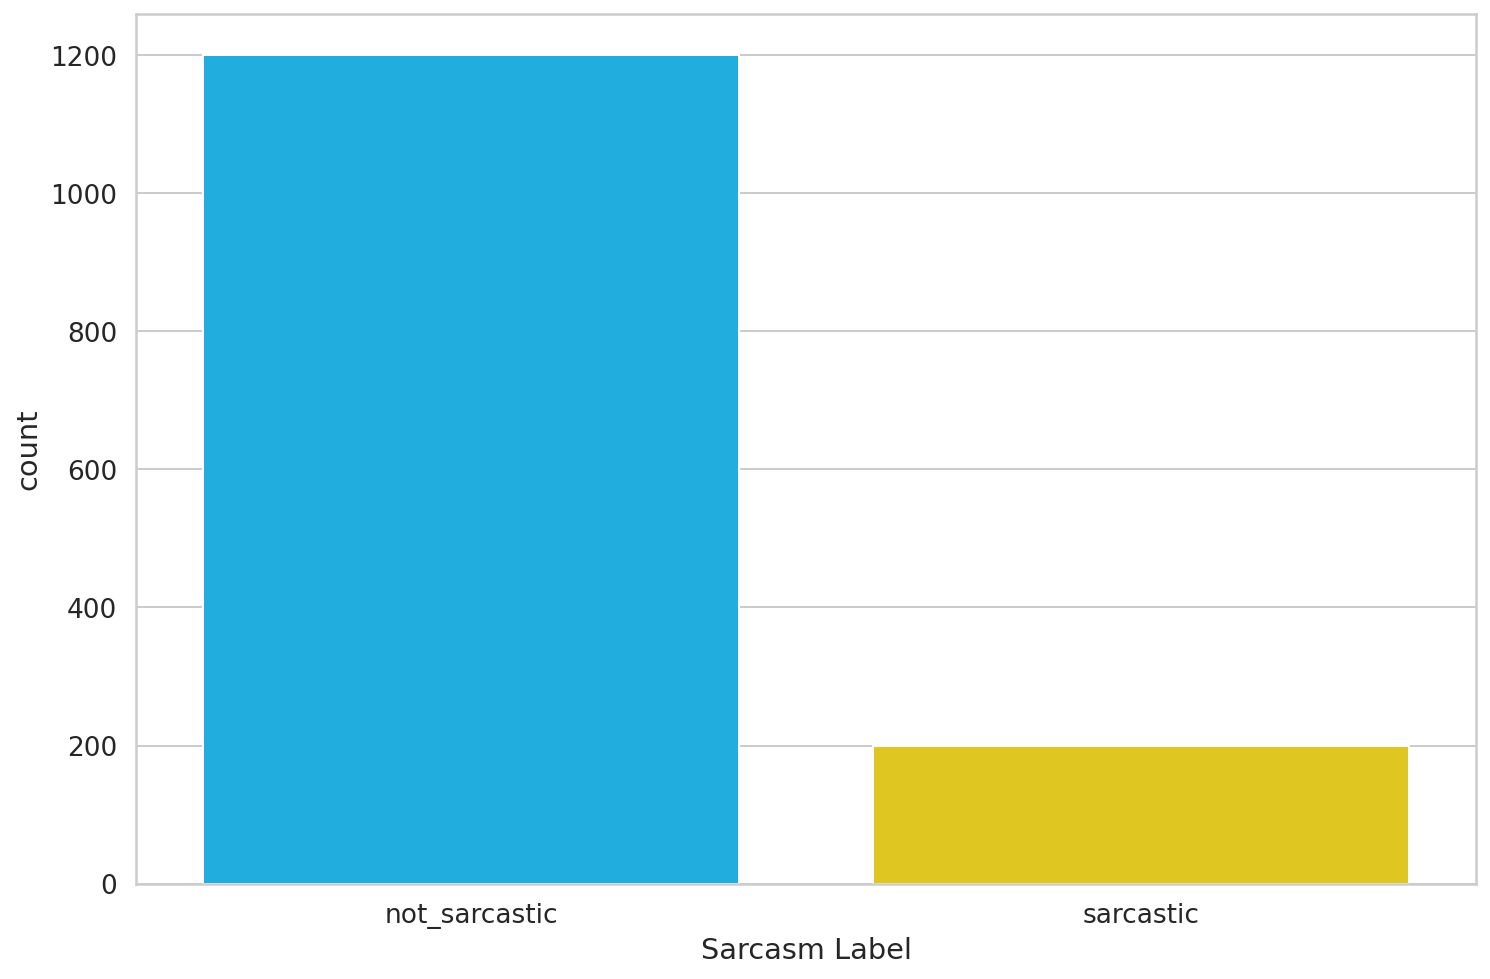

In [12]:
ax = sns.countplot(df_test.sarcastic)
s_t = 0
ns_t =0
for i in df_test.sarcastic:
    if i == 1:
        s_t+=1
    else:
        ns_t+=1
l_count = len(df_test.sarcastic)
print("test total", l_count, "sarcastic", s_t, "non sarcastic", ns_t)
# print(len([x for x in df_test.sarcastic))
plt.xlabel('Sarcasm Label')

ax.set_xticklabels(class_names);

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [13]:
PRE_TRAINED_MODEL_NAME = 'vinai/bertweet-large'
bertweet = AutoModel.from_pretrained("vinai/bertweet-large")

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sarcasm than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [14]:
#tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, normalization=True)

We'll use this text to understand the tokenization process:

In [15]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [16]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'Ġwas', 'ĠI', 'Ġlast', 'Ġoutside', '?', 'ĠI', 'Ġam', 'Ġstuck', 'Ġat', 'Ġhome', 'Ġfor', 'Ġ2', 'Ġweeks', '.']
Token IDs: [1779, 21, 38, 94, 751, 116, 38, 524, 4889, 23, 184, 13, 132, 688, 4]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [17]:
tokenizer.sep_token, tokenizer.sep_token_id

('</s>', 2)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [18]:
tokenizer.cls_token, tokenizer.cls_token_id

('<s>', 0)

There is also a special token for padding:

In [19]:
tokenizer.pad_token, tokenizer.pad_token_id

('<pad>', 1)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [20]:
tokenizer.unk_token, tokenizer.unk_token_id

('<unk>', 3)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [21]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [22]:
print(len(encoding['input_ids'][0]))
encoding['input_ids']

32


tensor([[   0, 1779,   21,   38,   94,  751,  116,   38,  524, 4889,   23,  184,
           13,  132,  688,    4,    2,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1]])

The attention mask has the same length:

In [23]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [24]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['<s>',
 'When',
 'Ġwas',
 'ĠI',
 'Ġlast',
 'Ġoutside',
 '?',
 'ĠI',
 'Ġam',
 'Ġstuck',
 'Ġat',
 'Ġhome',
 'Ġfor',
 'Ġ2',
 'Ġweeks',
 '.',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each tweet:

In [25]:
df=df_train
token_lens = []
for txt in df.tweet:
    try:
        tokens = tokenizer.encode(str(txt), max_length=130) #max_length=512
        token_lens.append(len(tokens))
    except:
        #nan
        print(txt)


In [26]:
np.argmax(token_lens)

1153

In [27]:
c = 0
for x in token_lens:
    if x > 50:
        c += 1
print(c)

274


and plot the distribution:

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


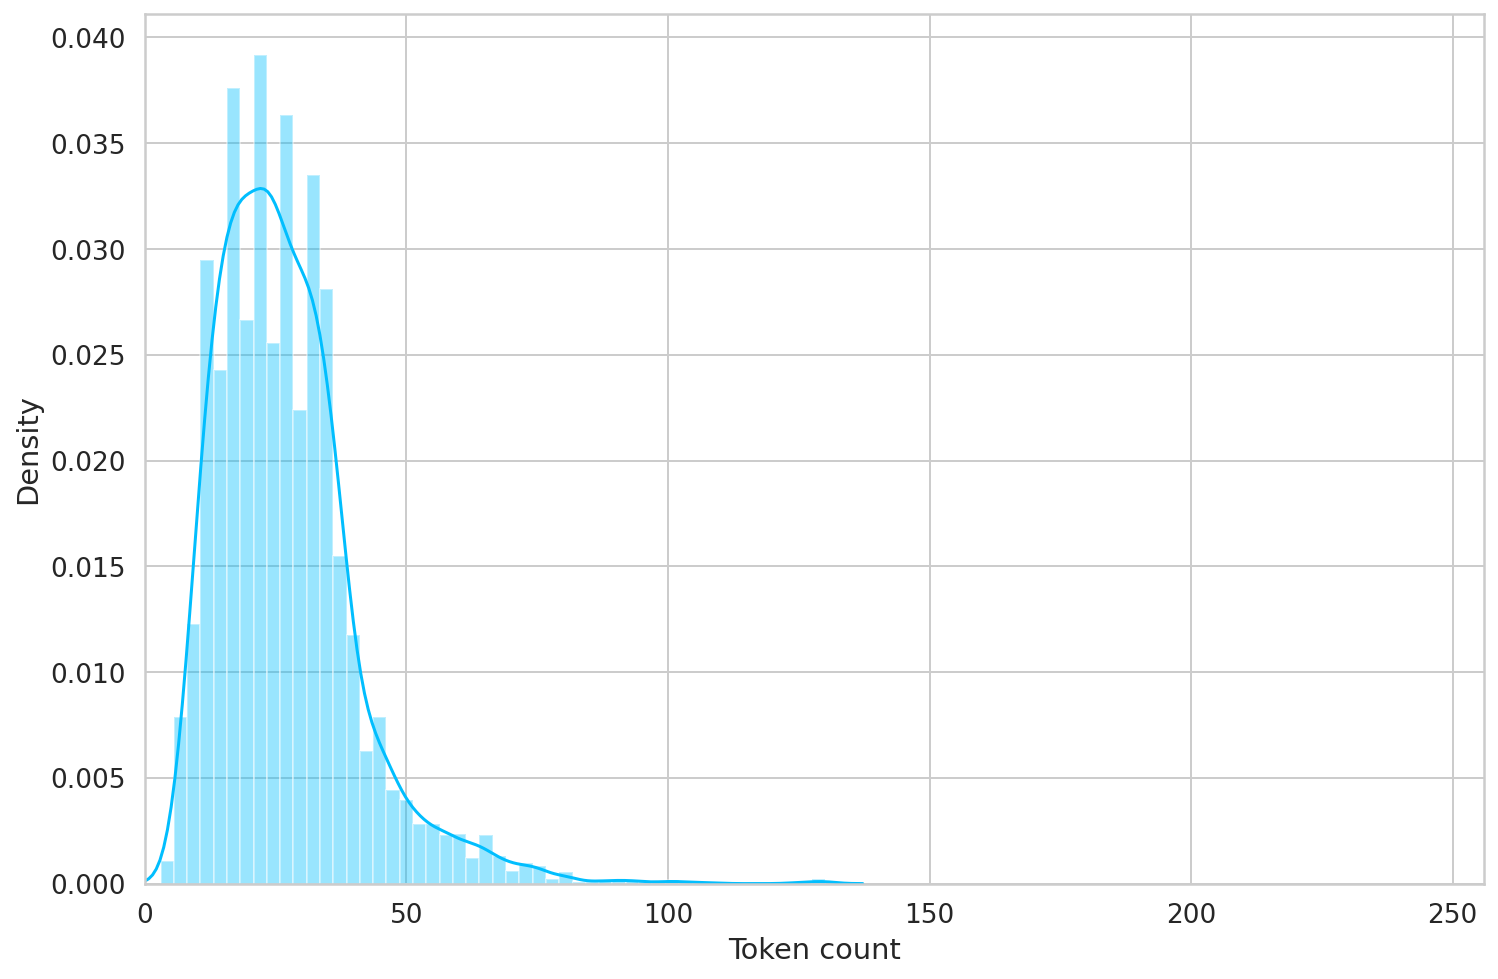

In [28]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the tweets seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [29]:
max(token_lens)

130

In [30]:
a = [3,5,9]
max(a)

9

In [31]:
MAX_LEN = 100

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [32]:
class GPTweetDataset(Dataset):

  def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the tweet texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [33]:
data = [['tom', 10], ['nick', 15], ['juli', 14]]

# Create the pandas DataFrame
dfx = pd.DataFrame(data, columns = ['Name', 'Age'])
print(dfx)
[x[0:2] for x in dfx.Name.to_numpy()]


   Name  Age
0   tom   10
1  nick   15
2  juli   14


['to', 'ni', 'ju']

In [34]:
df_train.shape, df_val.shape, df_test.shape

((5158, 10), (1387, 10), (1400, 10))

In [35]:
df_train.iloc[0]

tweet_id                                                            3388
tweet                  Whenever I get sad about how things are going ...
sarcastic                                                              0
rephrase                                                             NaN
sarcasm                                                              NaN
irony                                                                NaN
satire                                                               NaN
understatement                                                       NaN
overstatement                                                        NaN
rhetorical_question                                                  NaN
Name: 0, dtype: object

We also need to create a couple of data loaders. Here's a helper function to do it:

In [36]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPTweetDataset(
    tweets=df.tweet.to_numpy(),
    targets=df.sarcastic.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [37]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [38]:
data = next(iter(train_data_loader))
data.keys()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [39]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


## Sarcasm Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sarcasm classifier on top of it. Let's load the model:

In [40]:
#bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [41]:
last_hidden_state, pooled_output = bertweet(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict=False
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [42]:
last_hidden_state.shape

torch.Size([1, 32, 1024])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [43]:
bertweet.config.hidden_size

1024



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [44]:
pooled_output.shape

torch.Size([1, 1024])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [45]:
class SarcasmClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SarcasmClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [46]:
model = SarcasmClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

We'll move the example batch of our training data to the GPU:

In [47]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [48]:
print(input_ids.shape)
print(attention_mask.shape)
F.softmax(model(input_ids, attention_mask), dim=1)

torch.Size([16, 100])
torch.Size([16, 100])


tensor([[0.6568, 0.3432],
        [0.5508, 0.4492],
        [0.6148, 0.3852],
        [0.5293, 0.4707],
        [0.5263, 0.4737],
        [0.4686, 0.5314],
        [0.5482, 0.4518],
        [0.6500, 0.3500],
        [0.5778, 0.4222],
        [0.6186, 0.3814],
        [0.6288, 0.3712],
        [0.6098, 0.3902],
        [0.5817, 0.4183],
        [0.4899, 0.5101],
        [0.5965, 0.4035],
        [0.6126, 0.3874]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [49]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=4e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

#weights = [float(s_train)/(s_train+ns_train),float(ns_train)/(s_train+ns_train)] #as class distribution
weights = [float(1.0)/(ns_train),float(1.0)/(s_train)]
#weights = [float(1.0)/(math.sqrt(ns_train)),float(1.0)/(math.sqrt(s_train))]
# B=0.99
# E1=(1-pow(B, ns_train))/(1-B)
# w1=1/E1
# E2=(1-pow(B, s_train))/(1-B)
# w2=1/E2
# weights = [w1,w2]
class_weights = torch.FloatTensor(weights).cuda()
loss_fn = nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to(device)
#loss_fn = nn.CrossEntropyLoss().to(device)#CrossEntropyLoss() has already included a softmax layer inside.

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [50]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [51]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [52]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
      )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
      )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
  

Epoch 1/5
----------
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
hugging

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Train loss 0.44206491214203025 accuracy 0.7842186894145017
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARAL

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Val   loss 0.39862630893101636 accuracy 0.8103821196827685

Epoch 2/5
----------
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable t

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Train loss 0.28342561133425026 accuracy 0.8846452113222179
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling par

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Val   loss 0.47864541831030244 accuracy 0.8175919250180245

Epoch 3/5
----------
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already be

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Train loss 0.20306294288229623 accuracy 0.9286545172547499
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARAL

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Val   loss 0.7008786642142496 accuracy 0.8010093727469358

Epoch 4/5
----------
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already bee

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Train loss 0.16230754973907485 accuracy 0.9530825901512213
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Val   loss 0.8684981801351747 accuracy 0.8067772170151406

Epoch 5/5
----------
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid de

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Train loss 0.12728774759088768 accuracy 0.9641333850329584
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set 

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Val   loss 1.0118278869609723 accuracy 0.7916366258111031

CPU times: user 12min 39s, sys: 3min 11s, total: 15min 50s
Wall time: 16min 16s


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

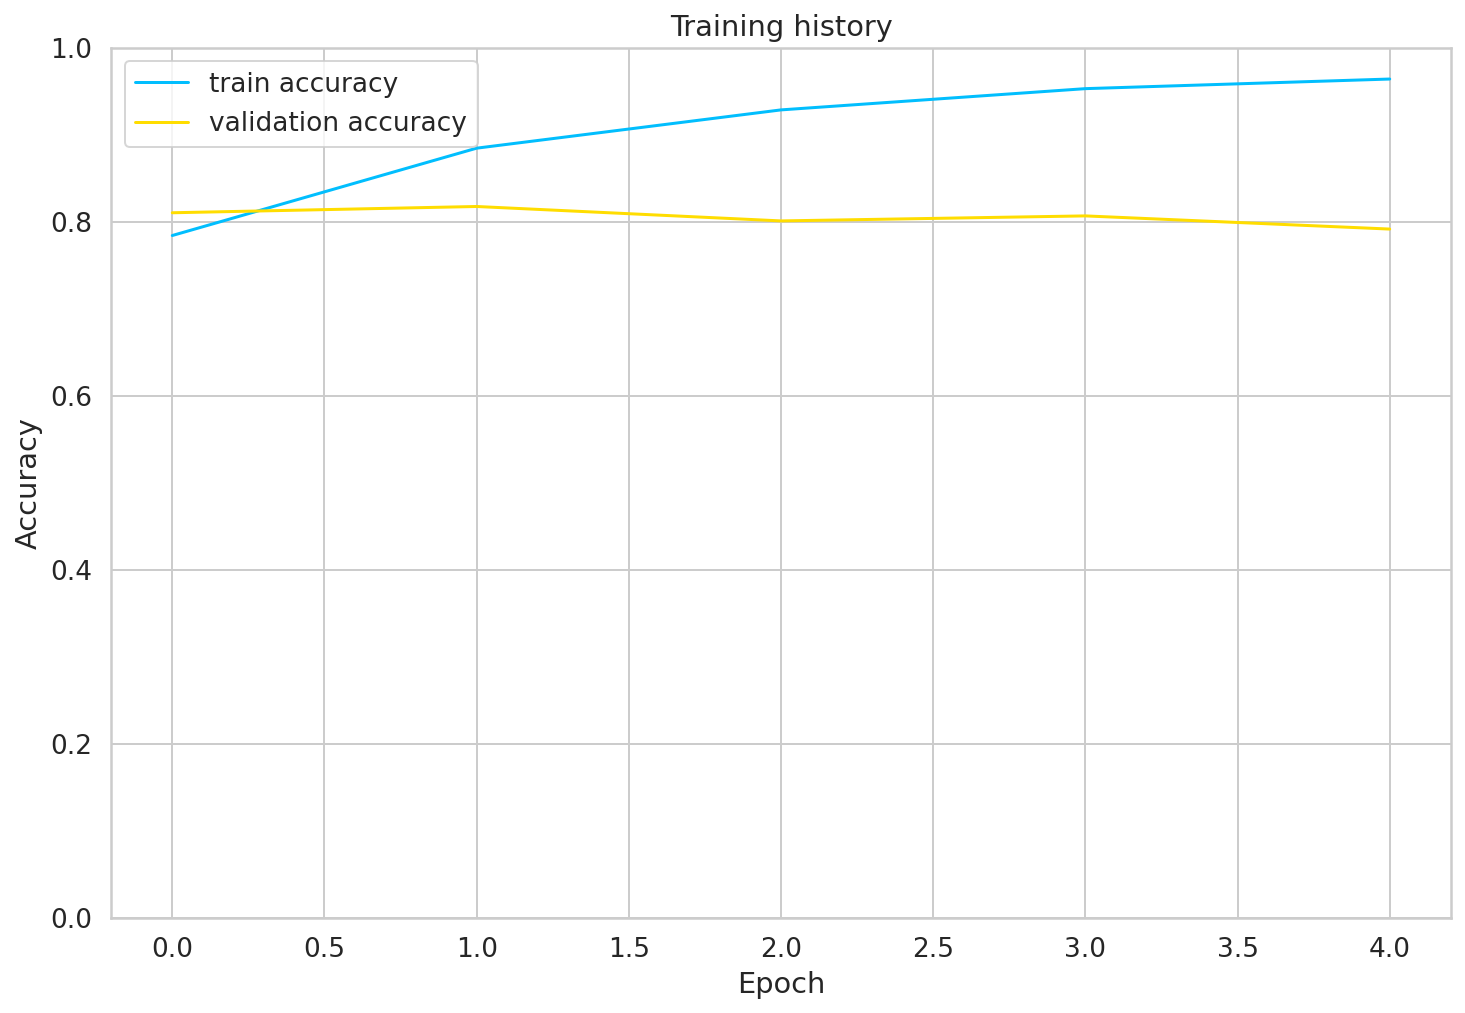

In [53]:
plt.plot(torch.tensor(history['train_acc'], device = 'cpu'), label='train accuracy')
plt.plot(torch.tensor(history['val_acc'], device = 'cpu'), label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [54]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SarcasmClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## Evaluation

So how good is our model on predicting sarcasm? Let's start by calculating the accuracy on the test data:

In [55]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


0.7571428571428571

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [56]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  tweet_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      tweet_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return tweet_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the tweets and the predicted probabilities (by applying the softmax on the model outputs):

In [57]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [58]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

               precision    recall  f1-score   support

not_sarcastic     0.8729    0.8452    0.8588      1040
    sarcastic     0.5763    0.6311    0.6025       347

     accuracy                         0.7916      1387
    macro avg     0.7246    0.7382    0.7306      1387
 weighted avg     0.7987    0.7916    0.7947      1387



In [59]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Let's have a look at the classification report

In [60]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

               precision    recall  f1-score   support

not_sarcastic     0.9526    0.7542    0.8419      1200
    sarcastic     0.3444    0.7750    0.4769       200

     accuracy                         0.7571      1400
    macro avg     0.6485    0.7646    0.6594      1400
 weighted avg     0.8657    0.7571    0.7897      1400



Looks like it is really hard to classify neutral (3 stars) tweets. And I can tell you from experience, looking at many tweets, those are hard to classify.

We'll continue with the confusion matrix:

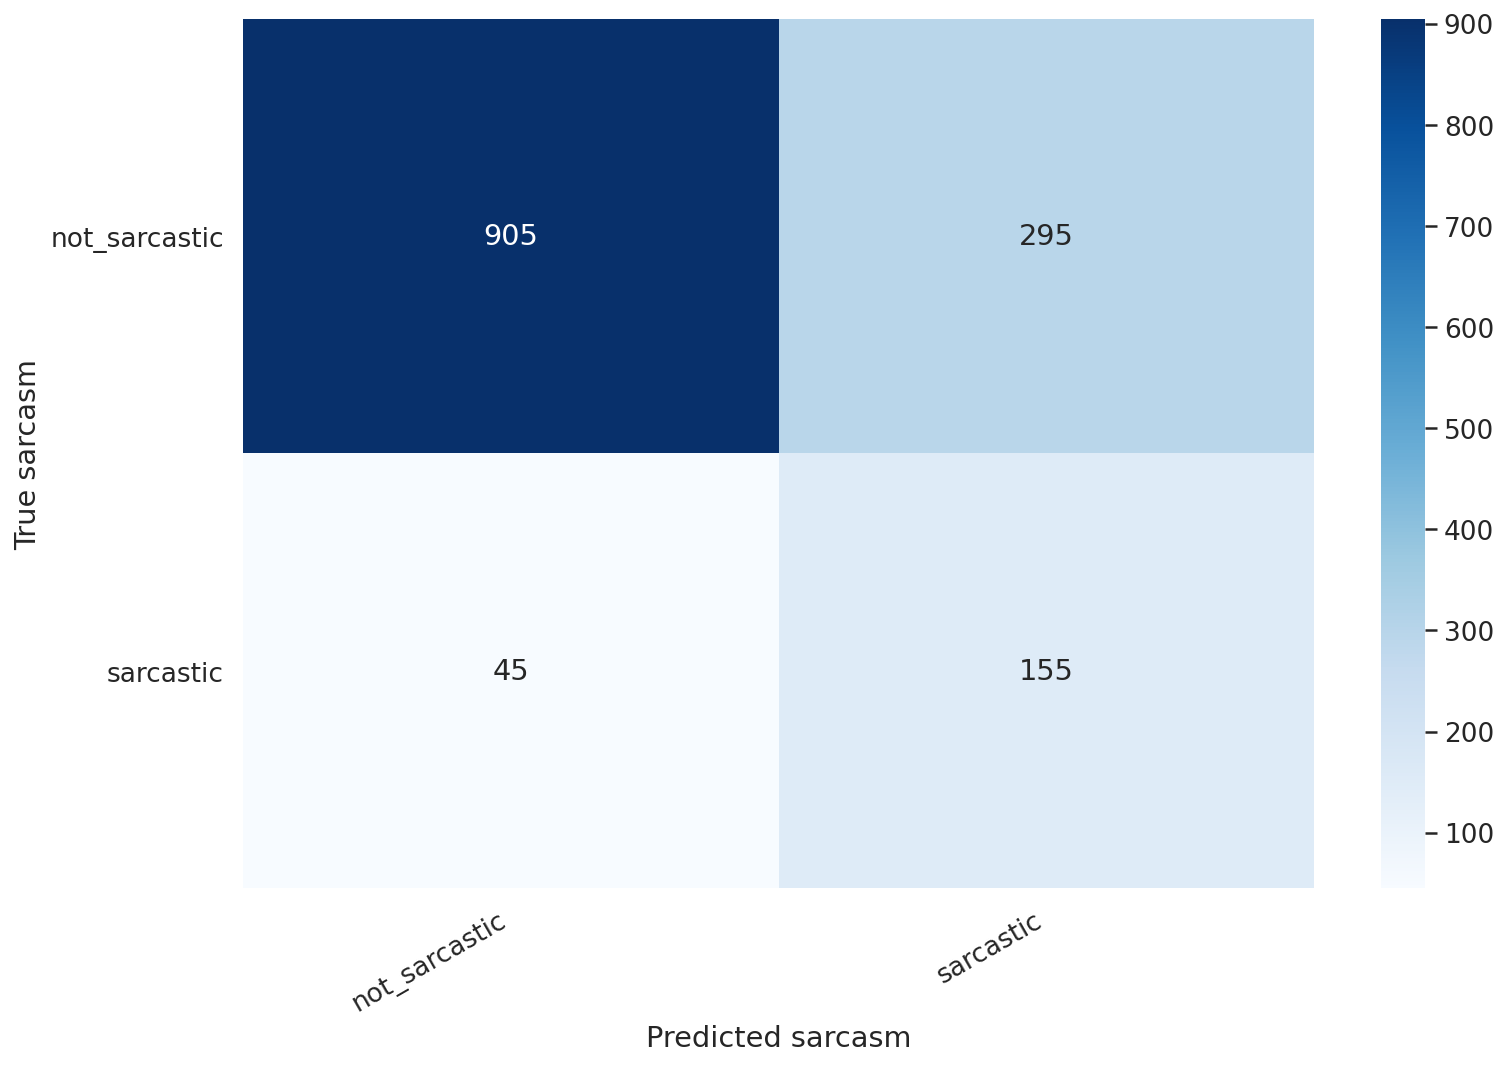

In [61]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sarcasm')
  plt.xlabel('Predicted sarcasm');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral tweets. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [62]:
idx = 2

tweet_text = y_tweet_texts[idx]
true_sarcasm = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [63]:
print("\n".join(wrap(tweet_text)))
print()
print(f'True sarcasm: {class_names[true_sarcasm]}')

So the Scottish Government want people to get their booster shots so
badly that the website doesn't even work

True sarcasm: sarcastic


In [64]:
y_pred_probs[idx]

tensor([5.5186e-04, 9.9945e-01])

Now we can look at the confidence of each sarcasm of our model:

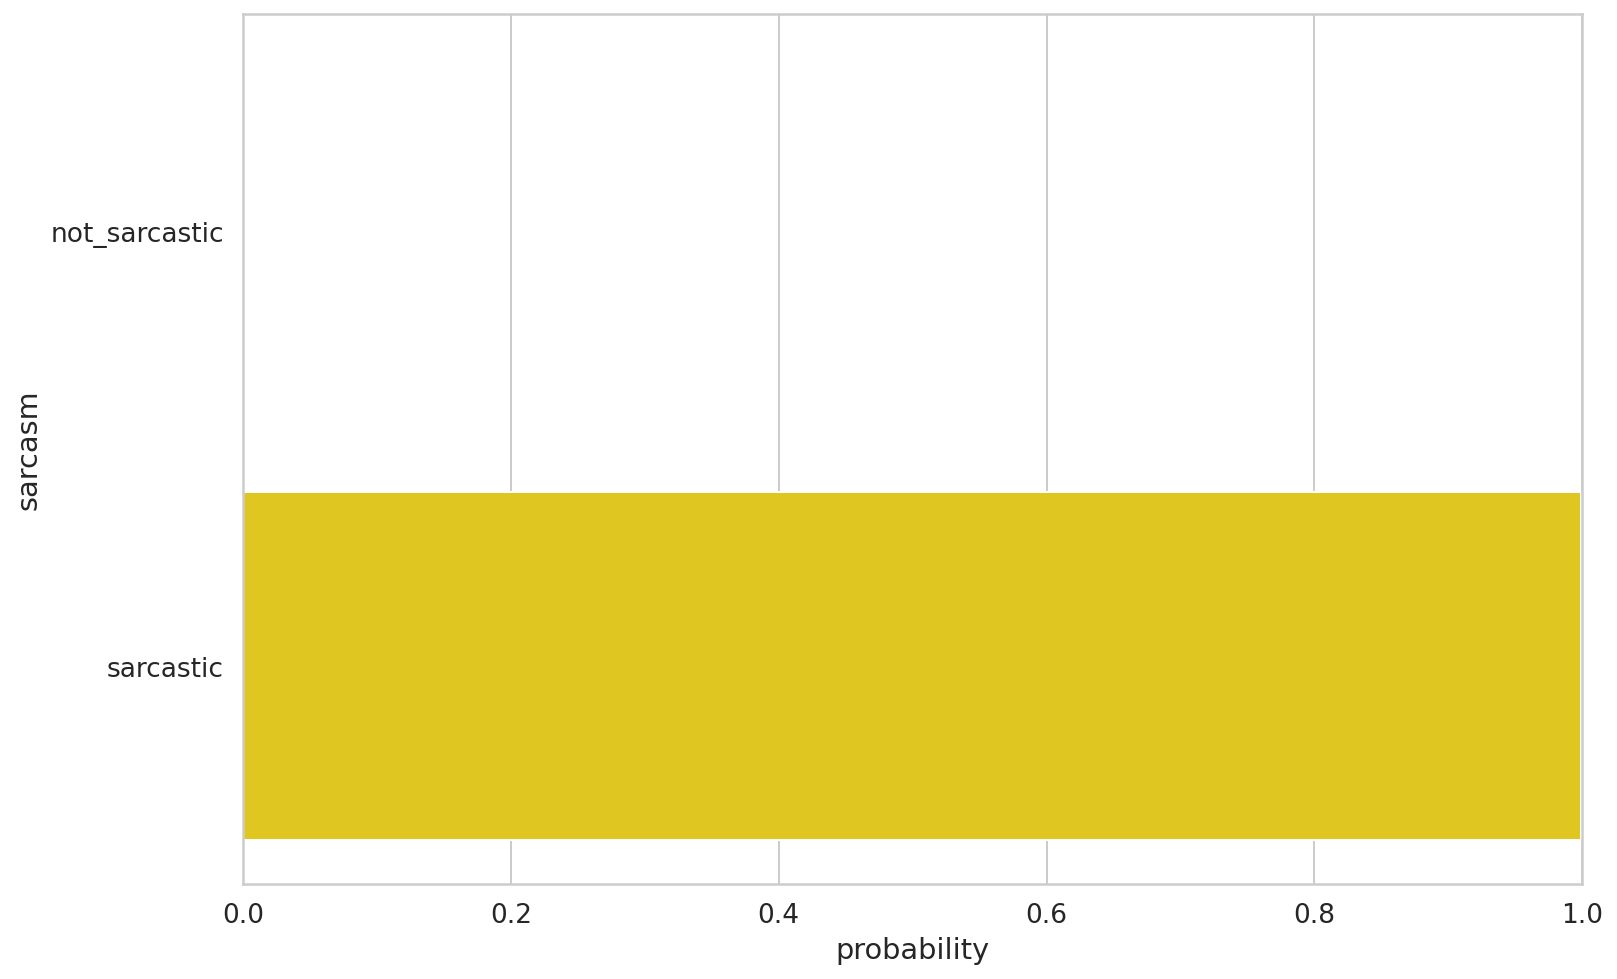

In [65]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sarcasm')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sarcasm of some raw text:

In [66]:
tweet_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

In [67]:
encoded_tweet = tokenizer.encode_plus(
  tweet_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/home/sknigam/anaconda3/envs/tweeter/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Let's get the predictions from our model:

In [68]:
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Tweet text: {tweet_text}')
print(f'Sarcasm  : {class_names[prediction]}')

Tweet text: I love completing my todos! Best app ever!!!
Sarcasm  : not_sarcastic
